In [3]:
from preprocessing.data_cleaning import get_cleaned_data, split_csv, get_features_label
from preprocessing.encoding import encode_data
from exploration.data_correlations import plot_correlations
from exploration.data_statistics import plot_labels_pie_chart, plot_blood_draw_statistics
from utils.utils import log_features
from modeling.mrmr import perform_mrmr
from exploration.midterm_exploration import plot_feature_against_diagnosis

In [2]:
df = encode_data(get_cleaned_data())
df = df[df["P1_PT_TYPE"] != 3]
log_features(df)
blood, clinical = split_csv(df)

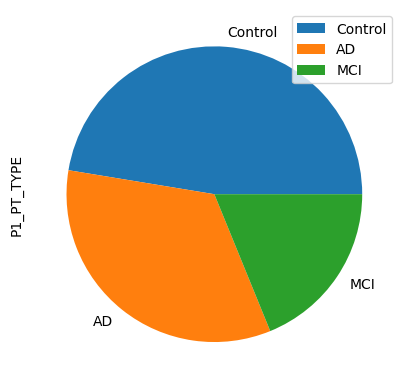

In [3]:
plot_labels_pie_chart(df, png="Pie Chart of Diagnoses")

In [ ]:
plot_blood_draw_statistics(df, png="Blood Draw Proportions")

In [ ]:
plot_correlations(df)

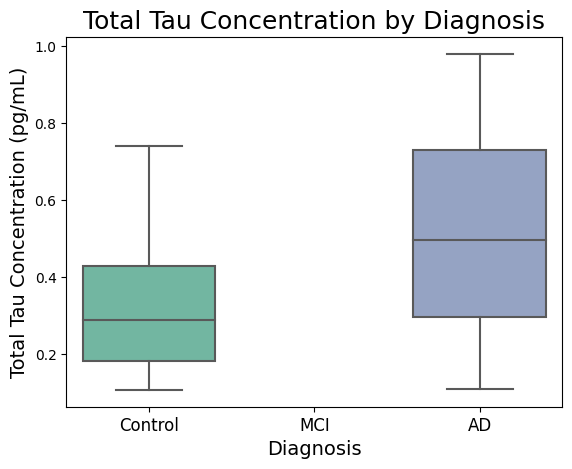

In [4]:
plot_feature_against_diagnosis(
    blood,
    "Q1_Total_tau",
    title="Total Tau Concentration by Diagnosis",
    ylabel="Total Tau Concentration (pg/mL)",
    png="Total Tau Concentration by Diagnosis"
)

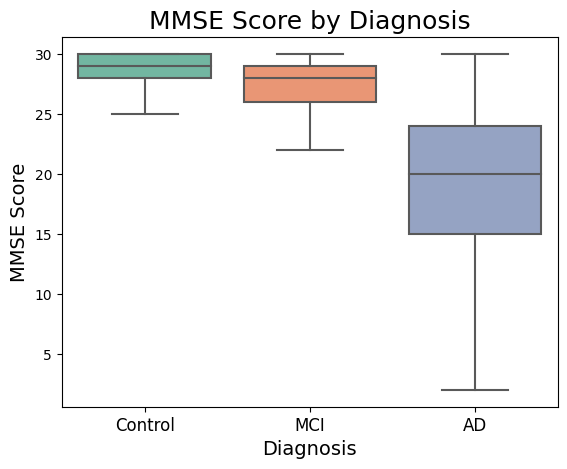

In [5]:
plot_feature_against_diagnosis(
    clinical,
    "C1_MMSE",
    title="MMSE Score by Diagnosis",
    ylabel="MMSE Score",
    png="MMSE Score by Diagnosis"
)

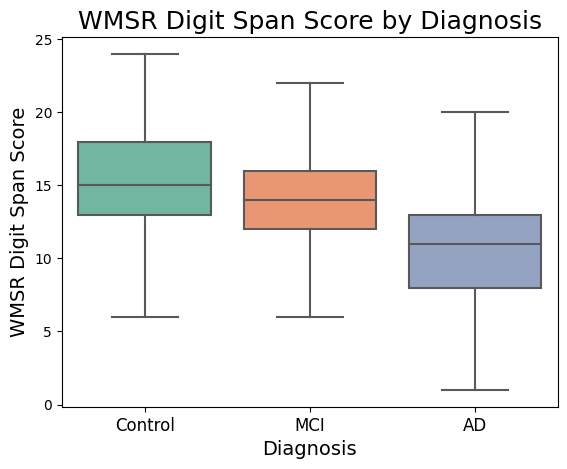

In [6]:
plot_feature_against_diagnosis(
    clinical,
    "C1_WMSR_DIGTOT",
    title="WMSR Digit Span Score by Diagnosis",
    ylabel="WMSR Digit Span Score",
    png="WMSR Digit Span Score by Diagnosis"
)

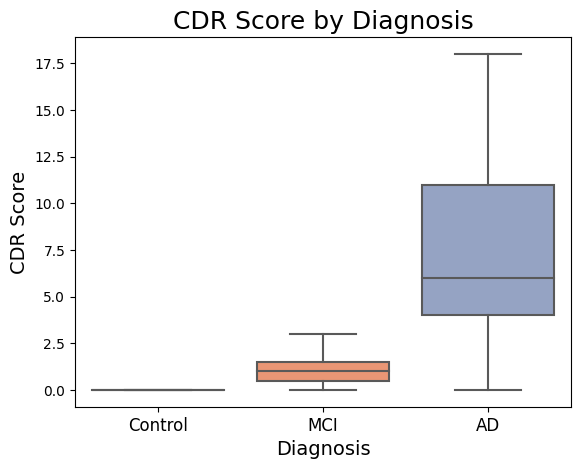

0.0    6638
0.5     153
1.0      58
1.5       7
2.5       6
2.0       6
Name: C1_CDRSUM, dtype: int64

In [7]:
plot_feature_against_diagnosis(
    clinical,
    "C1_CDRSUM",
    title="CDR Score by Diagnosis",
    ylabel="CDR Score",
    png="CDR Score by Diagnosis"
)

temp = clinical[clinical["P1_PT_TYPE"] == 2]
temp["C1_CDRSUM"].value_counts()

In [9]:
import pandas as pd

y, X = get_features_label(df)
y = pd.Series(y)

features, score, _ = perform_mrmr(X, y, 10, True)
print(score[features])

100%|██████████| 10/10 [00:05<00:00,  1.79it/s]

C1_CDRSUM         12246.970442
D1_DEPIF_2.0        320.684875
C1_CDRGLOB        10823.582862
D1_DEMUNIF_1.0      202.870377
C1_MMSE            7494.683432
C1_WMS3_LMEM2      5028.276859
F2_IADLTOTSCR      5185.036349
C1_SS_TRAILB       3959.703523
C1_WMS3_LMEM1      4529.604559
PATID              1626.602202
dtype: float64


In [ ]:
import pandas as pd
label_encoded_df = pd.get_dummies(blood, columns=["P1_PT_TYPE"])

correlations = blood.corr().abs().unstack()
ad_correlations = correlations["P1_PT_TYPE"].sort_values()
print(ad_correlations.index[:100])